# Part 3

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras import optimizers
from keras import initializers,regularizers
from math import sqrt

## Preprocessing


Number of total samples: 10000
Samples in the Training Set: 8000
Samples in Validation Set:2000
Length of each Sample:60


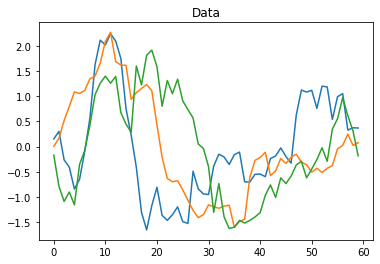

In [64]:
#filenames
str0="ts_comp_N10000"
fnamex = "x_"+str0+".csv"
fnamey = "y_"+str0+".csv"

#data
x = np.loadtxt(fnamex,delimiter=",",dtype=float)
N = len(x)

#we want to remove the average from each data
xm = x.mean(axis=1)
for n in range(N):
    x[n] = x[n] - xm[n] #data have now average 0
    
#remove the std and bring it back to 1
std = x.std(axis=1)
for n in range(N):
    x[n] = x[n] / std[n] #data have now average 0

#Labels
categ = np.loadtxt(fnamey,delimiter=",",dtype=int)
N_categ=3
y = np.zeros((N,N_categ))
for n in range(N):y[n][categ[n]] = 1 #one-hot encoding

#Training and Validation sets
perc_train = 0.8
N_train = int(N*perc_train)
N_val = N - N_train

x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]

L = len(x[0])

print(f"\nNumber of total samples: {N}\nSamples in the Training Set: {N_train}\nSamples in Validation Set:{N_val}\nLength of each Sample:{L}")

#reshape the data
x_train = x_train.reshape(x_train.shape[0],L,1)
x_val = x_val.reshape(x_val.shape[0],L,1)
input_shape = (L,1)

#plot the data
plt.title("Data")
plt.plot(x[0])
plt.plot(x[1])
plt.plot(x[2])
plt.show()

# CNN architectures

We want to find the best CNN architecture to properly solve our problem with this different set of data. The general requirements of these new CNNs are that:

* They must have **only one Convolutional layer** and as many Dense layers as we want.
* They must have the **number of total trainable parameters < 600**.

In order to look for the best architecture of the CNN, we defined several models with different number of hidden layers beside the convolutional one and we performed a Grid Search to select the best parameters for each model. All the combinations of parameters that we tried were previously checked to have a number of total trainable parameters smaller than 600.

## 1-hidden layer

In [65]:
#initialize empty list of best models
best_models = []
best_scores = []

np.random.seed(12345)
reg = regularizers.l1(1e-4) #lasso regularization
ini = initializers.RandomNormal(mean=0,stddev=0.05) #initialization of the weigths

#define the model
def create_model1(neurons, filters, kernel_size):
    
    new_model = Sequential()
    new_model.add(Conv1D(filters=filters,kernel_size=kernel_size, #parameters that can be tuned
                 kernel_regularizer=reg, 
                 kernel_initializer=ini,
                 activation="relu",
                 input_shape=input_shape
                 ))
    new_model.add(AveragePooling1D(5)) #first and only pooling; from 5 numbers to 1
    new_model.add(Flatten())
    new_model.add(Dense(neurons,activation="relu"))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(N_categ,activation="softmax"))

    #compile the model
    new_model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])
    
    return new_model

In [66]:
# create model
model1 = KerasClassifier(build_fn=create_model1, epochs=20, batch_size=50, verbose=0)

# define the grid search parameters
param_grid = [{'neurons':[10],'filters':[5],'kernel_size':[11]},
              {'neurons':[10],'filters':[5],'kernel_size':[17]},
              {'neurons':[15],'filters':[3],'kernel_size':[11]}]

grid = GridSearchCV(estimator=model1, param_grid=param_grid, n_jobs=1, cv=4, verbose=0)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#add best set of parameters to the list
best_models.append(grid_result.best_params_)
best_scores.append(grid_result.best_score_)

Best: 0.634625 using {'filters': 3, 'kernel_size': 11, 'neurons': 15}
0.579125 (0.063838) with: {'filters': 5, 'kernel_size': 11, 'neurons': 10}
0.623875 (0.053999) with: {'filters': 5, 'kernel_size': 17, 'neurons': 10}
0.634625 (0.064956) with: {'filters': 3, 'kernel_size': 11, 'neurons': 15}


## 2-hidden layer

In [67]:
#define the model
def create_model2(neuron1, neuron2, filters, kernel_size):
    
    new_model = Sequential()
    new_model.add(Conv1D(filters=filters,kernel_size=kernel_size, #parameters that can be tuned
                 kernel_regularizer=reg, 
                 kernel_initializer=ini,
                 activation="relu",
                 input_shape=input_shape
                 ))
    new_model.add(AveragePooling1D(5)) #first and only pooling; from 5 numbers to 1
    new_model.add(Flatten())
    new_model.add(Dense(neuron1,activation="relu"))
    new_model.add(Dense(neuron2,activation="relu"))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(N_categ,activation="softmax"))

    #compile the model
    new_model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])
    
    return new_model

In [68]:
# create model
model2 = KerasClassifier(build_fn=create_model2, epochs=20, batch_size=50, verbose=0)

# define the grid search parameters
param_grid = [{'neuron1':[5],'neuron2':[5],'filters':[5],'kernel_size':[11]},
              {'neuron1':[8],'neuron2':[5],'filters':[5],'kernel_size':[11]},
              {'neuron1':[10],'neuron2':[5],'filters':[3],'kernel_size':[11]},
              {'neuron1':[15],'neuron2':[5],'filters':[5],'kernel_size':[11]}]

grid = GridSearchCV(estimator=model2, param_grid=param_grid, n_jobs=1, cv=4, verbose=0)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#add best set of parameters to the list
best_models.append(grid_result.best_params_)
best_scores.append(grid_result.best_score_)

Best: 0.623375 using {'filters': 5, 'kernel_size': 11, 'neuron1': 5, 'neuron2': 5}
0.623375 (0.074395) with: {'filters': 5, 'kernel_size': 11, 'neuron1': 5, 'neuron2': 5}
0.599125 (0.061742) with: {'filters': 5, 'kernel_size': 11, 'neuron1': 8, 'neuron2': 5}
0.549500 (0.035192) with: {'filters': 3, 'kernel_size': 11, 'neuron1': 10, 'neuron2': 5}
0.570750 (0.045330) with: {'filters': 5, 'kernel_size': 11, 'neuron1': 15, 'neuron2': 5}


## 3-hidden layer

In [69]:
#define the model
def create_model3(neuron1, neuron2, neuron3,filters, kernel_size):
    
    new_model = Sequential()
    new_model.add(Conv1D(filters=filters,kernel_size=kernel_size, #parameters that can be tuned
                 kernel_regularizer=reg, 
                 kernel_initializer=ini,
                 activation="relu",
                 input_shape=input_shape
                 ))
    new_model.add(AveragePooling1D(5)) #first and only pooling; from 5 numbers to 1
    new_model.add(Flatten())
    new_model.add(Dense(neuron1,activation="relu"))
    new_model.add(Dense(neuron2,activation="relu"))
    new_model.add(Dense(neuron3,activation="relu"))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(N_categ,activation="softmax"))

    #compile the model
    new_model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])
    
    return new_model

In [70]:
# create model
model3 = KerasClassifier(build_fn=create_model3, epochs=20, batch_size=50, verbose=0)

param_grid = [{'neuron1':[8],'neuron2':[8],'neuron3':[5],'filters':[5],'kernel_size':[11]},
              {'neuron1':[10],'neuron2':[8],'neuron3':[5],'filters':[3],'kernel_size':[11]},
              {'neuron1':[10],'neuron2':[8],'neuron3':[8],'filters':[3],'kernel_size':[11]}]
              
grid = GridSearchCV(estimator=model3, param_grid=param_grid, n_jobs=1, cv=4, verbose=0)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
 
#add best set of parameters to the list
best_models.append(grid_result.best_params_)
best_scores.append(grid_result.best_score_)

Best: 0.633375 using {'filters': 5, 'kernel_size': 11, 'neuron1': 8, 'neuron2': 8, 'neuron3': 5}
0.633375 (0.044621) with: {'filters': 5, 'kernel_size': 11, 'neuron1': 8, 'neuron2': 8, 'neuron3': 5}
0.551500 (0.064477) with: {'filters': 3, 'kernel_size': 11, 'neuron1': 10, 'neuron2': 8, 'neuron3': 5}
0.570125 (0.060873) with: {'filters': 3, 'kernel_size': 11, 'neuron1': 10, 'neuron2': 8, 'neuron3': 8}


## 4-hidden layers

In [71]:
#function that creates the model with tunable parameters
def create_model4(neurons1,neurons2,neurons3,neurons4,filters,kernel_size):
    
    new_model = Sequential()
    new_model.add(Conv1D(filters=filters,kernel_size=kernel_size, #parameters that can be tuned
                 kernel_regularizer=reg, 
                 kernel_initializer=ini,
                 activation="relu",
                 input_shape=input_shape
                 ))

    new_model.add(AveragePooling1D(5)) #first and only pooling; from 5 numbers to 1
    new_model.add(Flatten())
    
    new_model.add(Dense(neurons1,activation="relu"))
    new_model.add(Dense(neurons2,activation="relu"))
    new_model.add(Dense(neurons3,activation="relu"))
    new_model.add(Dense(neurons4,activation="relu"))
    
    new_model.add(Dropout(0.2))
    new_model.add(Dense(N_categ,activation="softmax"))
    
    #compile the model
    new_model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])
    
    return new_model

In [72]:
#grisearch of best combination of parameters

# create model
model4 = KerasClassifier(build_fn=create_model4, epochs=20, batch_size=50, verbose=0)

# define the grid search parameters
param_grid = [{'neurons1':[5],'neurons2':[5],'neurons3':[5],'neurons4':[5],'filters':[5],'kernel_size':[11]},
              {'neurons1':[10],'neurons2':[10],'neurons3':[5],'neurons4':[5],'filters':[3],'kernel_size':[11]},
              {'neurons1':[10],'neurons2':[5],'neurons3':[5],'neurons4':[5],'filters':[3],'kernel_size':[11]},
              {'neurons1':[5],'neurons2':[5],'neurons3':[5],'neurons4':[5],'filters':[3],'kernel_size':[11]},
              {'neurons1':[10],'neurons2':[10],'neurons3':[5],'neurons4':[5],'filters':[3],'kernel_size':[7]},
              {'neurons1':[8],'neurons2':[8],'neurons3':[8],'neurons4':[8],'filters':[3],'kernel_size':[7]},
              {'neurons1':[8],'neurons2':[5],'neurons3':[5],'neurons4':[5],'filters':[5],'kernel_size':[11]}]

grid = GridSearchCV(estimator=model4, param_grid=param_grid, n_jobs=1, cv=4, verbose=0)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#add best set of parameters to the list
best_models.append(grid_result.best_params_)
best_scores.append(grid_result.best_score_)

print(best_models)
print(best_scores)

Best: 0.634625 using {'filters': 5, 'kernel_size': 11, 'neurons1': 8, 'neurons2': 5, 'neurons3': 5, 'neurons4': 5}
0.562875 (0.032089) with: {'filters': 5, 'kernel_size': 11, 'neurons1': 5, 'neurons2': 5, 'neurons3': 5, 'neurons4': 5}
0.603500 (0.060179) with: {'filters': 3, 'kernel_size': 11, 'neurons1': 10, 'neurons2': 10, 'neurons3': 5, 'neurons4': 5}
0.571750 (0.061616) with: {'filters': 3, 'kernel_size': 11, 'neurons1': 10, 'neurons2': 5, 'neurons3': 5, 'neurons4': 5}
0.546125 (0.033419) with: {'filters': 3, 'kernel_size': 11, 'neurons1': 5, 'neurons2': 5, 'neurons3': 5, 'neurons4': 5}
0.549875 (0.055929) with: {'filters': 3, 'kernel_size': 7, 'neurons1': 10, 'neurons2': 10, 'neurons3': 5, 'neurons4': 5}
0.524625 (0.027156) with: {'filters': 3, 'kernel_size': 7, 'neurons1': 8, 'neurons2': 8, 'neurons3': 8, 'neurons4': 8}
0.634625 (0.037194) with: {'filters': 5, 'kernel_size': 11, 'neurons1': 8, 'neurons2': 5, 'neurons3': 5, 'neurons4': 5}
[{'filters': 3, 'kernel_size': 11, 'neuron

After having found the best sets of parameters for the four different CNN architectures, we compared their performances and plotted the results.

The optimal parameters that we derived are:

* 1-layer: total trainable parameters=533
    * hidden layers=(15)
    * filters=3
    * kernel_size=11
      
* 2-layer: total trainable parameters=531
    * hidden layers=(5,5)
    * filters=5
    * kernel_size=11
           
* 3-layer: total trainable parameters=603
    * hidden layers=(8,8,5)
    * filters=5
    * kernel_size=11
* 4-layer: total trainable parameters=591
    * hidden layers=(8,5,5,5)
    * filters=5
    * kernel_size=11


In [73]:
batch_size = 50
epochs = 250

#define models with best parameters
model1=create_model1(**best_models[0])
model2=create_model2(**best_models[1])
model3=create_model3(**best_models[2])
model4=create_model4(**best_models[3])

#fit the models
fit1 = model1.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

fit2 = model2.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

fit3 = model3.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

fit4 = model4.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

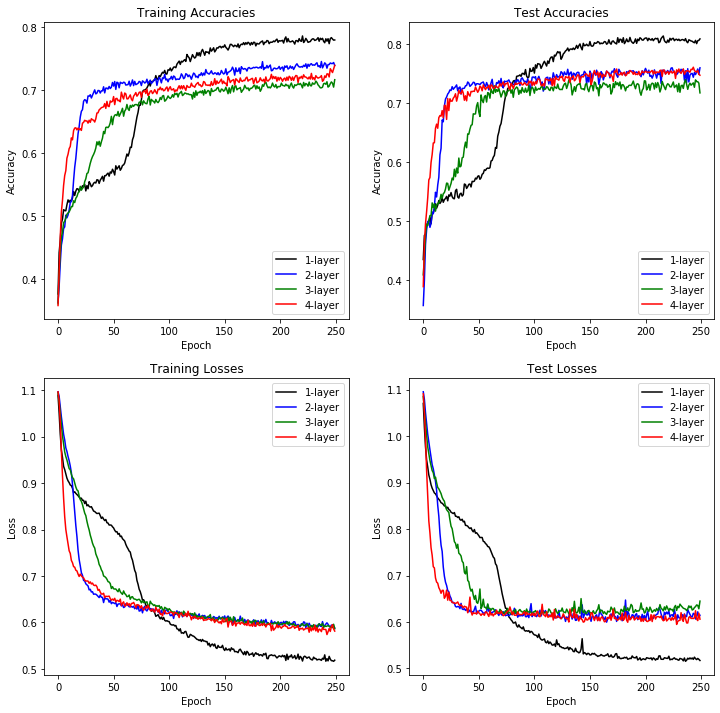

In [74]:
#evaluate performances
score1 = model1.evaluate(x_val, y_val, verbose=0)
score2 = model2.evaluate(x_val, y_val, verbose=0)
score3 = model3.evaluate(x_val, y_val, verbose=0)
score4 = model4.evaluate(x_val, y_val, verbose=0)

#plot
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(12,12))

#Training Accuracy
ax[0,0].plot(fit1.history['accuracy'],color='black')
ax[0,0].plot(fit2.history['accuracy'],color='blue')
ax[0,0].plot(fit3.history['accuracy'],color='green')
ax[0,0].plot(fit4.history['accuracy'],color='red')
ax[0,0].set_title("Training Accuracies")
ax[0,0].set_ylabel('Accuracy')
ax[0,0].set_xlabel('Epoch')
ax[0,0].legend(['1-layer', '2-layer', '3-layer', '4-layer'], loc='best')

#Test Accuracy
ax[0,1].plot(fit1.history['val_accuracy'],color='black')
ax[0,1].plot(fit2.history['val_accuracy'],color='blue')
ax[0,1].plot(fit3.history['val_accuracy'],color='green')
ax[0,1].plot(fit4.history['val_accuracy'],color='red')
ax[0,1].set_title("Test Accuracies")
ax[0,1].set_ylabel('Accuracy')
ax[0,1].set_xlabel('Epoch')
ax[0,1].legend(['1-layer', '2-layer', '3-layer', '4-layer'], loc='best')

#Training Loss
ax[1,0].plot(fit1.history['loss'],color='black')
ax[1,0].plot(fit2.history['loss'],color='blue')
ax[1,0].plot(fit3.history['loss'],color='green')
ax[1,0].plot(fit4.history['loss'],color='red')
ax[1,0].set_title("Training Losses")
ax[1,0].set_ylabel('Loss')
ax[1,0].set_xlabel('Epoch')
ax[1,0].legend(['1-layer', '2-layer', '3-layer', '4-layer'], loc='best')

#Test Loss
ax[1,1].plot(fit1.history['val_loss'],color='black')
ax[1,1].plot(fit2.history['val_loss'],color='blue')
ax[1,1].plot(fit3.history['val_loss'],color='green')
ax[1,1].plot(fit4.history['val_loss'],color='red')
ax[1,1].set_title("Test Losses")
ax[1,1].set_ylabel('Loss')
ax[1,1].set_xlabel('Epoch')
ax[1,1].legend(['1-layer', '2-layer', '3-layer', '4-layer'], loc='best')

plt.show()    

### Conclusion

From the images that we plotted, the most performing CNN architecture happens to be the one with **only one hidden layer** after the first convolutional one. The parameters that lead us to the best results are:

* Hidden Layer=(15)
* Filters=3
* Kernel_size=11

For this specific CNN configuration we obtained:
* Test Accuracy: 0.81
* Test Loss: 0.52

With 533 total trainable parameters.

When we were building the different models, we studied how the number of total trainable parameters varied when varying the number of hidden layers and the number of their neurons. We noticed that the presence of another Convolutional Layer guarantees that the total number of weights doesn't increase too fast, while when adding more Dense layers to the model we easily reach the maximum value of 600 total trainable parameters.

# Part 4

Keeping fixed the definition of the CNN model we want now play with the regularizer parameters (and other parameters)

In [94]:
#define the model
def create_model1(neurons = 15, filters = 4, kernel_size = 11, l1 = 0.001, l2 = 0.001):
    
    np.random.seed(12345)
    reg = regularizers.l1_l2(l1,l2) #lasso and ridge regularization
    #ini = initializers.RandomNormal(mean=0,stddev=sqrt(2/11)) #Kaiming initialization
    ini = initializers.RandomNormal(mean=0,stddev=0.05) #better results than above
    
    new_model = Sequential()
    new_model.add(Conv1D(filters=filters,kernel_size=kernel_size, #parameters that can be tuned
                 kernel_regularizer=reg, 
                 kernel_initializer=ini,
                 activation="relu",
                 input_shape=input_shape
                 ))
    new_model.add(AveragePooling1D(5)) #first and only pooling; from 5 numbers to 1
    new_model.add(Flatten())
    new_model.add(Dense(neurons,activation="relu"))
    new_model.add(Dropout(0.2))
    new_model.add(Dense(N_categ,activation="softmax"))

    #compile the model
    new_model.compile(loss=keras.losses.categorical_crossentropy, optimizer="adam", metrics=['accuracy'])
    
    return new_model

In [95]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=create_model1, 
                                   epochs=20, 
                                   batch_size=50, 
                                   verbose=0)

# list of allowed optional arguments for the optimizer, see compile_model()
l1 = [0.0001,0.001,0.01]
l2 = [0.0001,0.001,0.01]
# define parameter dictionary
param_grid = dict(l1=l1,l2=l2)
# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params) :
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.645000 using {'l1': 0.001, 'l2': 0.0001}
0.592375 (0.073159) with: {'l1': 0.0001, 'l2': 0.0001}
0.582750 (0.056412) with: {'l1': 0.0001, 'l2': 0.001}
0.566625 (0.071324) with: {'l1': 0.0001, 'l2': 0.01}
0.645000 (0.064882) with: {'l1': 0.001, 'l2': 0.0001}
0.583250 (0.069845) with: {'l1': 0.001, 'l2': 0.001}
0.606875 (0.069311) with: {'l1': 0.001, 'l2': 0.01}
0.508500 (0.014031) with: {'l1': 0.01, 'l2': 0.0001}
0.520125 (0.019011) with: {'l1': 0.01, 'l2': 0.001}
0.553750 (0.084260) with: {'l1': 0.01, 'l2': 0.01}


### Visualization of results

In [101]:
batch_size = 50
epochs = 250

#define models with differents parameters
model1=create_model1(neurons = 15, filters = 4, kernel_size = 11, l1 = 0.0001, l2 = 0.01)
model2=create_model1(neurons = 15, filters = 4, kernel_size = 11, l1 = 0.01, l2 = 0.0001)
model3=create_model1(neurons = 15, filters = 4, kernel_size = 11, l1 = 0.001, l2 = 0.0001)
model4=create_model1(neurons = 15, filters = 4, kernel_size = 11, l1 = 0.01, l2 = 0.01)
model5=create_model1(neurons = 15, filters = 4, kernel_size = 11, l1 = 0.0001, l2 = 0.0001)

#fit the models
fit1 = model1.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

fit2 = model2.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

fit3 = model3.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

fit4 = model4.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

fit5 = model5.fit(x_train,y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(x_val,y_val),
                verbose=0, shuffle=True)

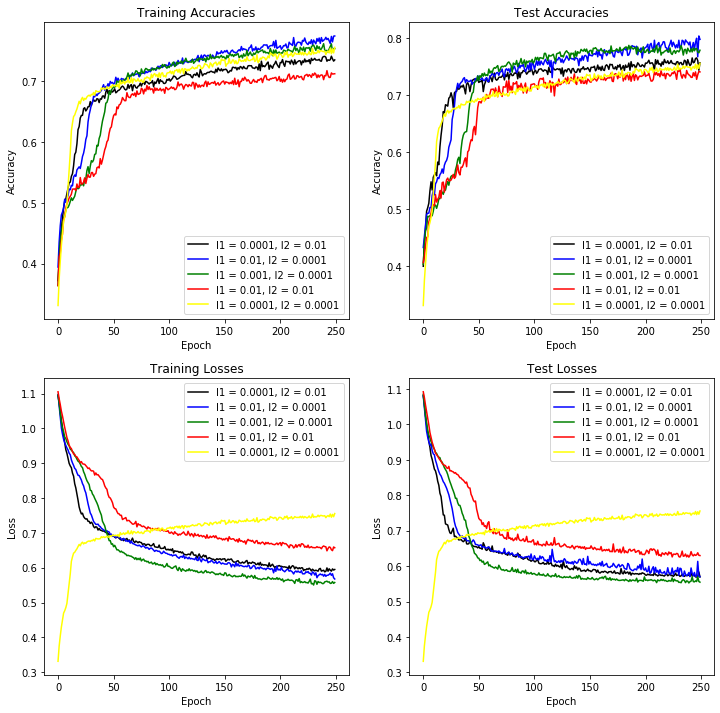

In [102]:
#evaluate performances
score1 = model1.evaluate(x_val, y_val, verbose=0)
score2 = model2.evaluate(x_val, y_val, verbose=0)
score3 = model3.evaluate(x_val, y_val, verbose=0)
score4 = model4.evaluate(x_val, y_val, verbose=0)
score5 = model5.evaluate(x_val, y_val, verbose=0)

#plot
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(12,12))

#Training Accuracy
ax[0,0].plot(fit1.history['accuracy'],color='black')
ax[0,0].plot(fit2.history['accuracy'],color='blue')
ax[0,0].plot(fit3.history['accuracy'],color='green')
ax[0,0].plot(fit4.history['accuracy'],color='red')
ax[0,0].plot(fit5.history['accuracy'],color='yellow')
ax[0,0].set_title("Training Accuracies")
ax[0,0].set_ylabel('Accuracy')
ax[0,0].set_xlabel('Epoch')
ax[0,0].legend(['l1 = 0.0001, l2 = 0.01', 'l1 = 0.01, l2 = 0.0001', 'l1 = 0.001, l2 = 0.0001', 'l1 = 0.01, l2 = 0.01', 'l1 = 0.0001, l2 = 0.0001'], loc='best')

#Test Accuracy
ax[0,1].plot(fit1.history['val_accuracy'],color='black')
ax[0,1].plot(fit2.history['val_accuracy'],color='blue')
ax[0,1].plot(fit3.history['val_accuracy'],color='green')
ax[0,1].plot(fit4.history['val_accuracy'],color='red')
ax[0,1].plot(fit5.history['accuracy'],color='yellow')
ax[0,1].set_title("Test Accuracies")
ax[0,1].set_ylabel('Accuracy')
ax[0,1].set_xlabel('Epoch')
ax[0,1].legend(['l1 = 0.0001, l2 = 0.01', 'l1 = 0.01, l2 = 0.0001', 'l1 = 0.001, l2 = 0.0001', 'l1 = 0.01, l2 = 0.01', 'l1 = 0.0001, l2 = 0.0001'], loc='best')

#Training Loss
ax[1,0].plot(fit1.history['loss'],color='black')
ax[1,0].plot(fit2.history['loss'],color='blue')
ax[1,0].plot(fit3.history['loss'],color='green')
ax[1,0].plot(fit4.history['loss'],color='red')
ax[1,0].plot(fit5.history['accuracy'],color='yellow')
ax[1,0].set_title("Training Losses")
ax[1,0].set_ylabel('Loss')
ax[1,0].set_xlabel('Epoch')
ax[1,0].legend(['l1 = 0.0001, l2 = 0.01', 'l1 = 0.01, l2 = 0.0001', 'l1 = 0.001, l2 = 0.0001', 'l1 = 0.01, l2 = 0.01', 'l1 = 0.0001, l2 = 0.0001'], loc='best')

#Test Loss
ax[1,1].plot(fit1.history['val_loss'],color='black')
ax[1,1].plot(fit2.history['val_loss'],color='blue')
ax[1,1].plot(fit3.history['val_loss'],color='green')
ax[1,1].plot(fit4.history['val_loss'],color='red')
ax[1,1].plot(fit5.history['accuracy'],color='yellow')
ax[1,1].set_title("Test Losses")
ax[1,1].set_ylabel('Loss')
ax[1,1].set_xlabel('Epoch')
ax[1,1].legend(['l1 = 0.0001, l2 = 0.01', 'l1 = 0.01, l2 = 0.0001', 'l1 = 0.001, l2 = 0.0001', 'l1 = 0.01, l2 = 0.01', 'l1 = 0.0001, l2 = 0.0001'], loc='best')

plt.show()   

The grid search does not perform a good optimization, we should be repeat it with a larger numeber of epochs but this is computational expansive. So we see the plots for finding that the best intermediate regularization values for l1 and l2 are 0.01 and 0.0001:

* Test Accuracy: 0.80
* Test Loss: 0.57

The best result changing the regularization is about he same that befr

### Weights visualization

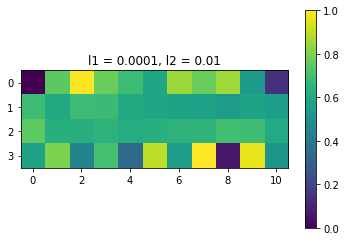

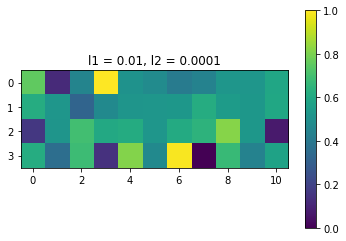

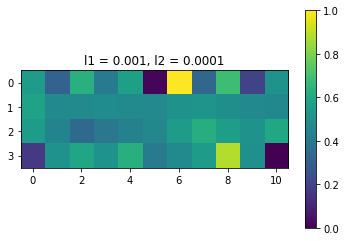

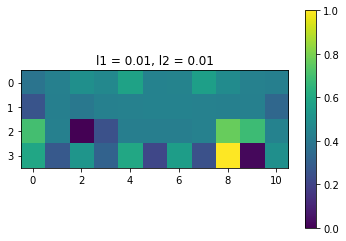

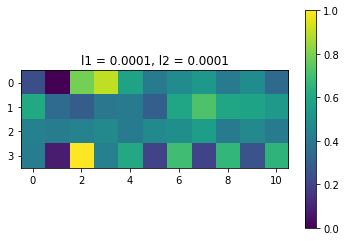

In [147]:
titles = ['l1 = 0.0001, l2 = 0.01', 'l1 = 0.01, l2 = 0.0001', 'l1 = 0.001, l2 = 0.0001', 'l1 = 0.01, l2 = 0.01', 'l1 = 0.0001, l2 = 0.0001']


i = 0
for models in [model1,model2,model3,model4,model5]:
    # check for convolutional layer

    layer = models.layers[0]
    # get filter weights
    filters, biases = layer.get_weights()
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)
    # plot filters

    plt.imshow(filters.T[:,0,:])
    plt.colorbar()
    plt.title(titles[i])
    plt.show()
    i += 1

### Conclusion

We tried five different normalizations to plot the weights. Each normalization leads to completely different plots but the numerical results remain similar.